# Chapter 8: Nonlinear Oscillations
## Wilson-Cowan Network Oscillator, FigzHugh-Nagumo Equations, Hopf Bifurcations, Delayed Negative Feedback, Adaptation and Perceptual Reversals

### Dependencies

In [84]:
using DifferentialEquations
using NLsolve
using Roots
using PyPlot
using Plots
using PyCall

In [154]:
function mypoly(x)
    """
    Returns the coefficient of the characteristic polynomial for a square matrix 
    representing a linearized series of higher order differential equations
    """
    (m,n) = size(x)

    if m == n
       e = eig(x)
    elseif (m==1) || (n==1)
       e = x
    else
        error("Input size is wrong")
    end

    if length(e) > 1
        e = e[1]
    end

    # Expand recursion formula
    n = length(e)
    c = [1 zeros(1,n)]
    c = complex(c)

    for j=1:n
        c[2:(j+1)] = c[2:(j+1)] - e[j].*c[1:j]
    end

    # The result should be real if the roots are complex conjugates.
    if isequal(sort(real(e[imag(e).>0])), sort(conj(real(e[imag(e).<0]))))
         c = real(c)
    end

    return c
end


mypoly (generic function with 1 method)

## Equilibrium of Naka-Rushton Equation using fzero
$S(x) = \frac{MP^N}{\sigma ^N + P^n}$

### Define the equations

In [96]:
# Naka-Rushton Equation
function nrush(x, M, σ)
    return (M*x^2)/(σ^2 + x^2) 
end

# Naka-Rushton Inverse
function nrushinv(M, y, sigma)
    if y <= 0 || y >= M
        error("Error: y must be between 0 and M")
        return false
    else
        return sigma*sqrt( (y) / (M - y))
    end
end

# WCequilib.m
function WCequilib(X)
    H1 = 1.6*X + 20 - 30*sqrt(X/(100 - X)); # Inverse Naka-Rushton Equation
    H2 = 100*2.25*X^2/((900 + 2.25*X^2)); # Naka-Rushton Equation with M = 100, N = 2, sigma = 30
    ISS = H2 - H1;
end

WCequilib (generic function with 1 method)

### Use fzero, initially guessing between 0 and 15

In [97]:
fzero(WCequilib, [0, 15])

12.766395420826774

## Wilson-Cowan Network Oscillator



<center>$\large \frac{dE}{dt} = \frac{1}{\tau}(-E + S(1.6E - I + K))$</center>


<center>$\large \frac{dI}{dt} = \frac{1}{\tau}(-I + S(1.5E))$</center>


#### We will be using \tau = 5 for dE/dt and \tau = 10 for dI/dt

In [4]:
function WCoscillator(Stim)
    DT = 0.5 # Time step
    Final_Time = 400 # Final time
    Last = Int64(Final_Time./DT + 1)
    Time = DT.*(0:Last-1) # Time vector
    Tau = 5 # Time constant
    TauI = 10 # Time constant for inhibitory neuron
    WTS = [1 2 2 1]
    
    # Pre-initialize arrays for speed
    X = Array{Float64}(2, 801)
    K = Array{Float64}(2, 4)
    Weights = Array{Float64}(2, 4)
    
    # THIS LOOP WORKS
    for NU = 1:2 # Two equations
        X[NU, :] = zeros(1, Last) 
        K[NU, :] = zeros(1, 4)
        Weights[NU, :] = WTS
    end
    
    
    Wt2 = [0 .5 .5 1] # Runge-Kutta weights
    rkIndex = [1 1 2 3] # Runge-Kutta index

    tic() # Start timing
    
    # THIS LOOP WORKS
    for T = 2:Last # For each time point
        for rk = 1:4 # Fourth order Runge-Kutta
            
            # Define X(n+1)
            XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk]

            
            PSP1 = Stim + 1.6*XH[1] - XH[2]
            PSP1 = PSP1*(PSP1.>0)

            # Update K matrix
            K[1, rk] = DT/Tau*(-XH[1] + 100*PSP1^2/(30^2 + PSP1^2))
            K[2, rk] = DT/TauI*(-XH[2] + 100*(1.5*XH[1])^2/(30^2 + (1.5*XH[1])^2))
            

        end
        # Assign the time point X[:, T]
        X[:, T] = X[:, T-1] + sum((Weights.*K)', 1)'/6
    end
    
    figure(1)
    plt = PyPlot.plot(Time, X[1, :], "r", Time, X[2, :], "b")
    xlabel("Time")
    ylabel("Spike rate")
    legend("EI")
    
    figure(2)
    
    Xiso = 0:1:99
    Isocline1 = 1.6*Xiso + Stim - 30*sqrt(Xiso./(100 - Xiso))
    Isocline2 = 100*(1.5*Xiso).^2./(30^2 + (1.5*Xiso).^2)
    
    xlabel("E")
    ylabel("I")
    
    (XX, Y) = meshgrid(0:5:100)
    P1 = Stim + 1.6*XX - Y;
    P1 = P1.*(P1 .> 0);
    DX = -XX + 100*(P1.^2)./(30^2 + P1.^2)
    P2 = 1.5*XX
    DY = -Y + 100*(P2.^2)./(30^2 + P2.^2)
    Scale = 1./sqrt((DX.^2 + DY.^2))
    DX = DX.*Scale
    DY = DY.*Scale
    
    # Plot everything
    plt = PyPlot.plot(X[1, :], X[2, :], "b", Xiso, Isocline1, "g", Xiso, Isocline2, "r")
    xlim(0, 100)
    ylim(0, 100)
    PyPlot.quiver(XX, Y, DX, DY, 0.75)
    
    
    return X, Xiso, Isocline1, Isocline2
end

WCoscillator (generic function with 1 method)

### Wilson-Cowan Output

In [ ]:
WCoscillator(20)

## Van der Pol Equations 

<center>$\large \frac{dx}{dt} = y$</center>

<center>$\large \frac{dy}{dt} = -\omega^2x + y(\beta - x^2)$</center>

In [6]:
function VanDerPol(Beta)
    
    Total_Equations = 2
    DT = 0.02
    Final_Time = 20
    Last = Int64(Final_Time./DT + 1)
    Time = DT.*(0:Last-1)
    Tau = 20
#     Beta = input('Hopf parameter Beta = ');
    WTS = [1 2 2 1]
    
    # Pre-initialize arrays for speed
    X = Array{Float64}(2, Last)
    K = Array{Float64}(2, 4)
    Weights = Array{Float64}(2, 4)
    
    # THIS LOOP WORKS
    for NU = 1:2 # Two equations
        X[NU, :] = zeros(1, Last) 
        K[NU, :] = zeros(1, 4)
        
        # Initial Conditions
        X[1, 1] = 1
        X[2, 1] = 0
        Weights[NU, :] = WTS
    end
    
    # Define RK weigts
    Wt2 = [0 .5 .5 1]
    rkIndex = [1 1 2 3]
    Stim = 0

    
    for T = 2:Last 
        for rk = 1:4 
            # Calculate X(T+h)
            XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk]
            
            # Van der Pol Equations
            K[1, rk] = DT*(XH[2]) 
            K[2, rk] = DT*(XH[2]*(Beta - XH[1]^2) - 25*XH[1]);

        end
        
        # Assign the time point X[:, T]
        X[:, T] = X[:, T-1] + sum((Weights.*K)', 1)'/6
    end

    figure(1)
    PyPlot.plot(Time, X[1, :], "r", Time, X[2, :], "b")
    
    # Plot the oscillator
    figure(2)
    SSp = PyPlot.plot(X[1,:], X[2, :], "r")
    xlabel("X")
    ylabel("Y")
    title("Phase Plane")
    MX = maximum(X[1, :])
    MN = minimum(X[1, :])
    XX = 1.5*MN:1.5*(MX - MN)/20:1.5*MX
    YMX = maximum(X[2, :]) 
    YMN = minimum(X[2, :])
    YY = 1.5*YMN:1.5*(YMX - YMN)/20:1.5*YMX
    (X, Y) = meshgrid(XX, YY)
    DX = Y
    DY = -25*X + Y.*(Beta - X.^2)
    Scale = 1./sqrt((DX.^2 + DY.^2))
    DX = DX.*Scale
    DY = DY.*Scale
    PyPlot.quiver(X, Y, DX, DY, 1/2)
    
end

VanDerPol (generic function with 1 method)

### Van der Pol Output (asymtotically stable for beta < 0)


elapsed time: 0.000895271 seconds


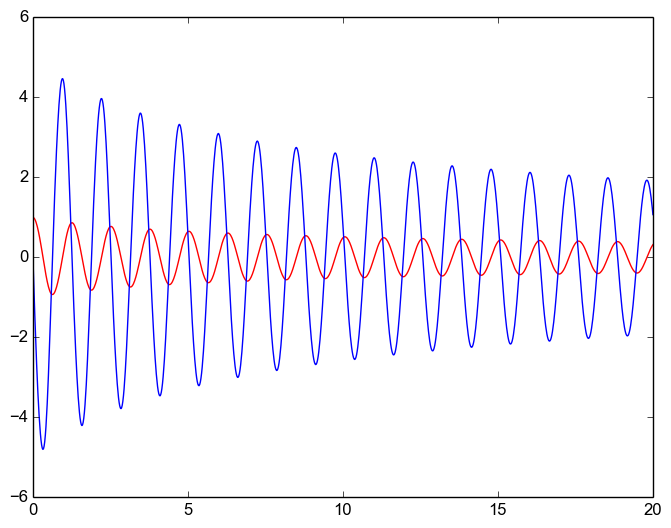

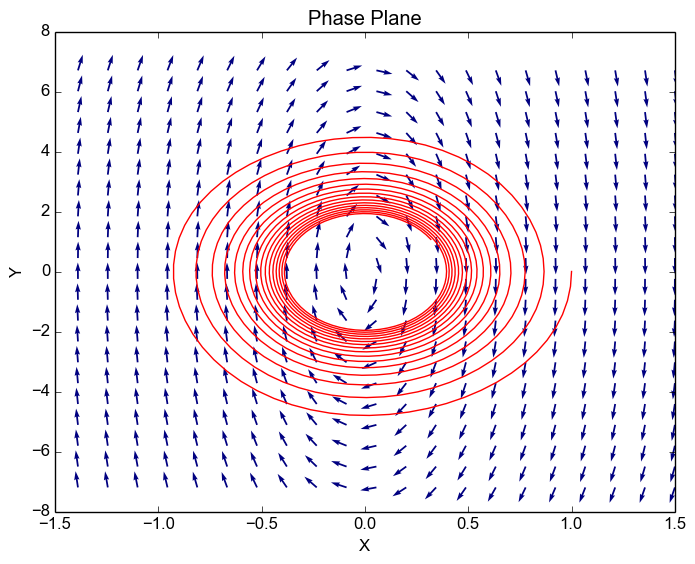

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] sqrt(::Array{Float64,2}) at ./deprecated.jl:57
 [3] VanDerPol(::Float64) at ./In[6]:72
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/vis-528/.julia/v0.6/IJulia/src/execute_request.jl:160
 [6] eventloop(::ZMQ.Socket) at /home/vis-528/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##11#14)() at ./task.jl:335
while loading In[147], in expression starting on line 1


PyObject <matplotlib.quiver.Quiver object at 0x7f8621658b90>

In [147]:
VanDerPol(-.01)

## Hopf calculation to be used in the Routh-Hurwitz Equation for n>=2 dimensions

In [155]:
function Hopf(G)
    # Uses Routh-Hurwitz to find Oscillatory solution for Hopf Bifurcation
    
    # Hard coded for right now
    A = [-1/20 0 0 -1/20; (1/G) (-1/G) 0 0; 0 6/50 -1/50 0; 0 0 (1/G) (-1/G)] # This is the linearized diff eq system
    
    Cf = mypoly(A)
    Sz = length(Cf) - 1
    RH = zeros(Sz, Sz)
    
    for Row = 1:Sz    #set-up Routh-Hurwitz matrix
        Index = 2*Row +1
        for Column = 1:Sz
            Index = Index - 1
            if (Index > 0) && (Index <= (Sz+1))
                RH[Row, Column] = Cf[Index]
            end
        end
    end

    Osc = det(RH[1:Sz-1, 1:Sz-1])
end



10.744811229036381

In [163]:
function RouthHurwitz() # Still need to actually make this function manipulable
    """
    Uses the Hopf bifurcation theorem to decide where and if a Hopf bifurcation occurs, 
    and what sort of limit cycle will be produced in the phase plane
    """
    
    Guess = 5
    A = [-1/20 0 0 -1/20; 1/Guess -1/Guess 0 0; 0 6/50 -1/50 0; 0 0 1/Guess -1/Guess];
    G = -3.2470e-16 # TODO: fzero(Hopf, 1) can't get fzero to be the same as MATLAB, but I could for the WC Oscillator
    G = fzero(Hopf, 5)
    Stimulus = [1 1 1]
    Cf = mypoly(A)
    Characteristic_Eqn = Cf
    EigenValues = eig(A)


    if sum(Cf .>= 0) != length(Cf);  # %Check to make sure that all coefficients are > zero
        error("Equilibrium point is unstable because some characteristic eqn coefficients are <= 0!")
    end

    Sz = length(Cf) - 1
    RH = zeros(Sz, Sz)
    for Row = 1:Sz  # %set-up Routh-Hurwitz matrix
        Index = 2*Row +1
        for Column = 1:Sz
            Index = Index - 1
            if (Index > 0) && (Index .<= (Sz+1))
                RH[Row, Column] = Cf[Index]
            end
        end
    end

    RHDet = zeros(1, 4)

    for K = 1:Sz;
        RHDet[K] = det(RH[1:K, 1:K]);
    end

    RHDet = RHDet.*(abs.(RHDet) .> 10.0^(-9));
    RHDeterminants = RHDet'

    if sum(RHDet .> 0) == length(RHDet);
        result = "Equilibrium point is asymptotically stable!"
    end
    if sum(RHDet .< -10.0^(-6)) > 0;
        result = "Equilibrium Point is Unstable!"
    end
    if RHDet[Sz-1] == 0;
        result = "Solution oscillates around equilibrium point, which is a center!"
    end
    
    hopf_bifurcation = G
    
    return hopf_bifurcation, result
end

RouthHurwitz (generic function with 1 method)

### Test stability of an example system of equations (see RouthHurwitz() for that example)

In [164]:
hopf_bifurcation, limit_cycle = RouthHurwitz()

(10.744811229036381, "Equilibrium point is asymptotically stable!")

### Adaptation and Perceptual Reversals

dE1dt, dE2dt, dA1dt, dA2dt

In [165]:
function WTAdapt(Beta)
    """
    Simulates four neurons
    """
    Total_Equations = 4  # %Solve for this number of interacting Neurons
    DT = 5  # %Time increment as fraction of time constant
    Final_Time = 60000   # %Final time value for calculation
    Last = Int64(Final_Time/DT + 1)  # %Last time step
    Time = DT.*(0:Last-1)  # %Time vector
    Tau = 20  # %Neural time constants in msec
    TauA = 600

    # Beta = input('Adaptation parameter beta (>0) = ');

    # Pre-initialize arrays for speed
    X = Array{Float64}(Total_Equations, length(Time))
    K = Array{Float64}(Total_Equations, 4)
    Weights = Array{Float64}(Total_Equations, 4)

    @show "DEBUG1"
    WTS = [1 2 2 1] # %Runge-Kutta Coefficient weights
    @show "DEBUG2"
    for NU = 1:Total_Equations # %Initialize
        @show NU
        X[NU, :] = zeros(1, Last) # %Vector to store response of Neuron #1
        K[NU, :] = zeros(1, 4) # %Runge-Kutta terms	
        X[1, 1] = 1 # %Initial conditions here if different from zero
        X[2, 1] = 0 # %Initial conditions here if different from zero
        Weights[NU, :] = WTS # %Make into matrix for efficiency in main loop
    end

    Wt2 = [0 .5 .5 1] # %Second set of RK weights
    rkIndex = [1 1 2 3]
    Stim1 = 150
    Stim2 = 150
    tic()

    for T = 2:Last
        for rk = 1:4 # %Fourth Order Runge-Kutta

            XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk]

            PSP1 = (Stim1 - 3.2*XH[2])*(XH[2] .< Stim1/3.2)
            PSP2 = (Stim2 - 3.2*XH[1])*(XH[1] .< Stim2/3.2)

            K[1, rk] = DT/Tau*(-XH[1] + 100*(PSP1)^2/((120 + XH[3])^2 + (PSP1)^2)) #%Your Equation Here
            K[2, rk] = DT/Tau*(-XH[2] + 100*(PSP2)^2/((120 + XH[4])^2 + (PSP2)^2))   # %Your Equation Here
            K[3, rk] = DT/TauA*(-XH[3] + Beta*XH[1]);
            K[4, rk] = DT/TauA*(-XH[4] + Beta*XH[2]);

     end;
        X[:, T] = X[:, T-1] + sum((Weights.*K)', 1)'/6 #weight matrix
    end;
    toc()
    
    Xiso = 0:100
    Isocline1 = (100*(Stim1 - 3*Xiso).^2)./(120^2 + (Stim1 - 3*Xiso).^2).*(3*Xiso .< Stim1)
    Isocline2 = (100*(Stim2 - 3*Xiso).^2)./(120^2 + (Stim2 - 3*Xiso).^2).*(3*Xiso .< Stim2)
    
    figure(1)
    Za = PyPlot.plot(Time, X[1, :], "r", Time, X[2, :], "b")
    xlabel("Time (ms)")
    ylabel("E1 (red) and E2 (blue)")
    
    ### TODO: Put E1, E2 and A1 into a 3D plot ###
    figure(2)
    Zb = PyPlot.plot(X[1, :], X[2, :], "r", Xiso, Isocline1, "-k", Isocline2, Xiso, "--k")
    xlabel("E1")
    ylabel("E2")
    title("E1-E2 Projection of State Space")
    
    figure(3)
    ZC = PyPlot.plot(X[3, :], X[1, :], "-r")
    xlabel("A1")
    ylabel("E1")
    title("E1-A1 Projection of State Space")
    
end

WTAdapt (generic function with 2 methods)

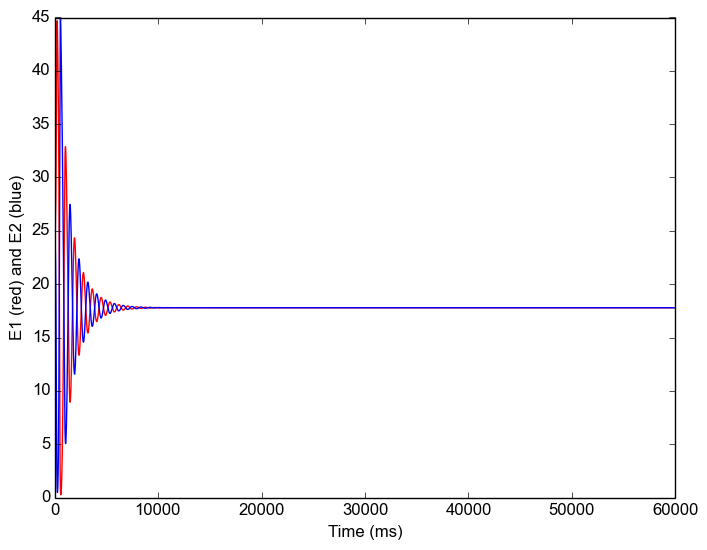

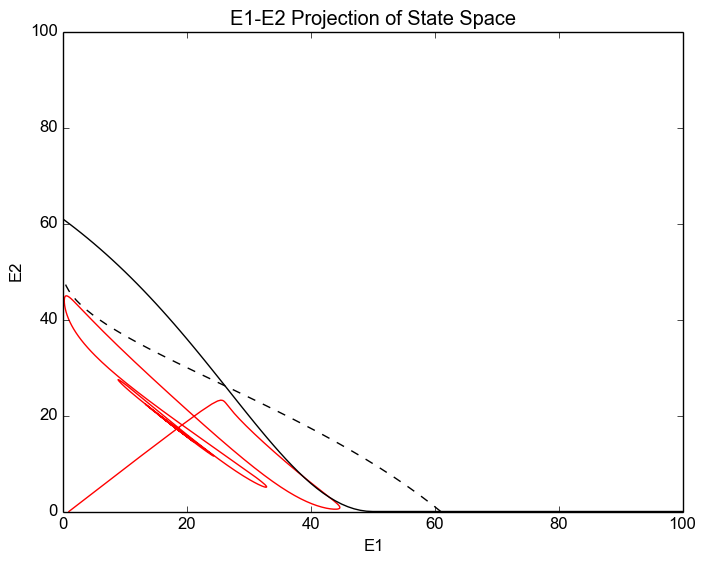

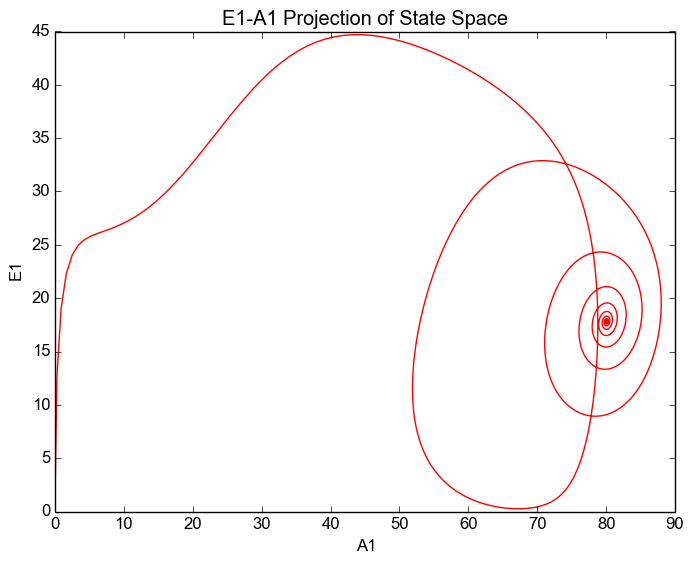

"DEBUG1" = "DEBUG1"
"DEBUG2" = "DEBUG2"
NU = 1
NU = 2
NU = 3
NU = 4
elapsed time: 0.017424752 seconds


PyObject <matplotlib.text.Text object at 0x7f862149cad0>

In [166]:
WTAdapt(4.5)

## FitzHugh-Nagumo Equations

<center>$\large \frac{dV}{dt}=10(V-\frac{V^3}{3}-R+I_{input})$</center>

<center>$\large \frac{dR}{dt}=0.8(-R+1.25V+1.5)$</center>


<center>What they lack in rigor, they provide in simplicity. They're basic but can still display limit cycles which models the threshold for spike generation.</center>

In [170]:
function FitzHugh(Input)
    Total_Equations = 2
    DT = 0.005
    Final_Time = 10
    Last = Int64(Final_Time/DT + 1)
    Time = DT*(0:Last-1)
    Tau = 0.1
    TauR = 1.25
    WTS = [1 2 2 1]

    # Pre-initialize arrays for speed
    X = Array{Float64}(Total_Equations, length(Time))
    K = Array{Float64}(Total_Equations, 4)
    Weights = Array{Float64}(Total_Equations, 4)

    for NU = 1:Total_Equations
        X[NU, :] = zeros(1, Last)
        K[NU, :] = zeros(1, 4)
        X[1, 1] = -1.5
        X[2, 1] = -3/8
        Weights[NU, :] = WTS
    end

    Wt2 = [0 .5 .5 1]
    rkIndex = [1 1 2 3]
    Input = 1.5 # Input = input('Stimulus strength = ');


    for T = 2:Last;
        for rk = 1:4  # Fourth Order Runge-Kutta
            XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk]
            Tme =Time[T-1] + Wt2[rk]*DT

            K[1, rk] = DT/Tau*(XH[1] - XH[1]^3/3 - XH[2] + Input)
            K[2, rk] = DT/TauR*(-XH[2] + 1.25*XH[1] + 1.5)

        end
        X[:, T] = X[:, T-1] + sum((Weights.*K)', 1)'/6 
    end

    Xiso = -3.2:0.01:3.2
    Isocline1 = Xiso - Xiso.^3/3 + Input
    Isocline2 = Xiso/0.8 + 1.5
    figure(1) 
    Za = PyPlot.plot(Time, X[1, :], "r-", Time, X[2, :], "b-")
    ylabel("V and R") 
    xlabel("Time (ms)")
    legend(["V(t)", "R(t)"])
    figure(2)
    Zb = PyPlot.plot(X[1, :], X[2, :], "-r", Xiso, Isocline1, "-k", Xiso, Isocline2, "--k")
    xlabel("V")
    ylabel("R")
end

FitzHugh (generic function with 1 method)

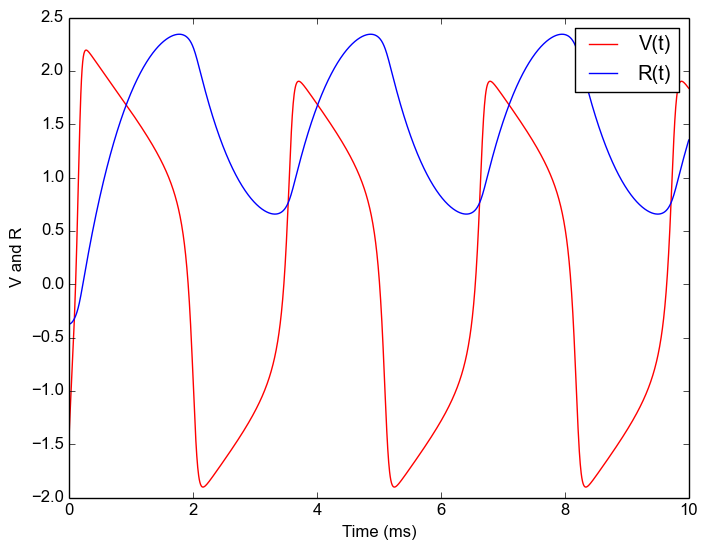

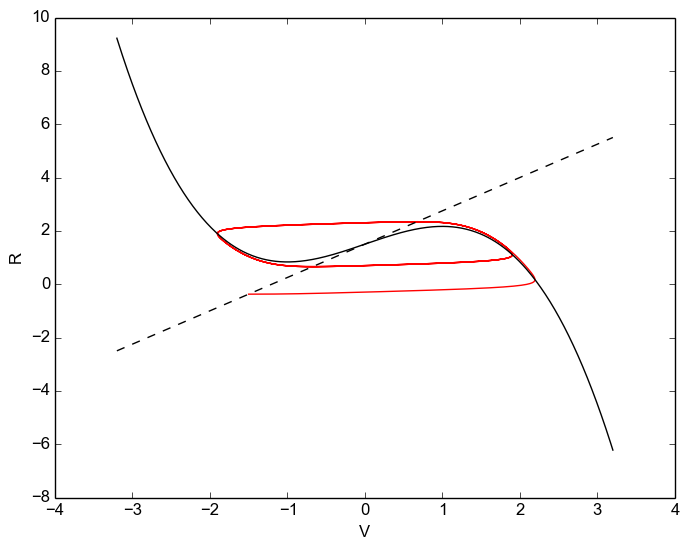

PyObject <matplotlib.text.Text object at 0x7f86213ea8d0>

In [171]:
FitzHugh(1.5)

## Delayed Negative Feedback
#### Example of a four-dimensional negative feedback circuit

<center>$\large \frac{dE}{dt}=\frac{1}{20}(-E+S(K-\Delta_{2}))$</center>
<center>$\large \frac{d\Delta_{1}}{dt}=\frac{1}{\tau}(-\Delta_{1}+E)$</center>
<center>$\large \frac{dI}{dt}=\frac{1}{50}(-I + 6\Delta_{1})$</center>
<center>$\large \frac{\Delta_{2}}{dt}=\frac{1}{\tau}(-\Delta_{2}+I)$</center>
<center>$\large S(P)=\frac{100P^2}{50^+P^2} for p >= 0; otherwise S(P)=0$</center>

In [173]:
function DelayedNegativeFeedback(Delay)# Delay
    Total_Equations = 4
    DT = 1
    Final_Time = 1000
    Last = Int64(Final_Time/DT + 1)
    Time = DT*(0:Last-1) 
    Tau = 20  
    TauI = 50
    TauD = Delay#TauD = input('Time constant for delays = ');
    WTS = [1 2 2 1]

    # Pre-initialize arrays for speed
    X = Array{Float64}(Total_Equations, length(Time))
    K = Array{Float64}(Total_Equations, 4)
    Weights = Array{Float64}(Total_Equations, 4)

    for NU = 1:Total_Equations

        X[NU, :] = zeros(1, Last)
        K[NU, :] = zeros(1, 4)
        X[1, 1] = 0;  #%Initial conditions here if different from zero
        X[2, 1] = 0;  #%Initial conditions here if different from zero
        Weights[NU, :] = WTS
    end

    Wt2 = [0 .5 .5 1]  
    rkIndex = [1 1 2 3]
    KK = 350

    for T = 2:Last
        for rk = 1:4 
            XH = X[:, T-1] + K[:, rkIndex[rk]]*Wt2[rk];

            PSP = KK - XH[4]
            PSP = PSP*(PSP .> 0)
            K[1, rk] = DT/Tau*(-XH[1] + (100*PSP^2)/(50^2 + PSP^2))#%Your Equation Here
            K[2, rk] = DT/TauI*(-XH[2] + 6*XH[3]) # %Your Equation Here
            K[3, rk] = DT/TauD*(-XH[3] + XH[1])
            K[4, rk] = DT/TauD*(-XH[4] + XH[2])

         end
        X[:, T] = X[:, T-1] + sum((Weights.*K)', 1)'/6 
    end

    TrueSol = 2*Time.*exp(-Time/20);

    figure(1)
    Za = PyPlot.plot(Time, X[1, :], "r")
    xlabel("Time (ms)")
    ylabel("E(t)")

    figure(2)
    SSp = PyPlot.plot(X[1, :], X[2, :], "r-")
    xlabel("E")
    ylabel("I")
    title("E-I Projection of State Space")
end


LoadError: [91msyntax: "10.74" is not a valid function argument name[39m

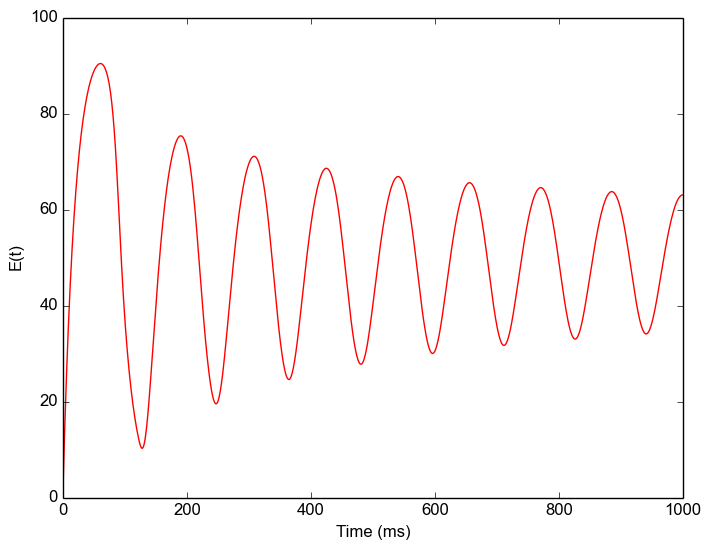

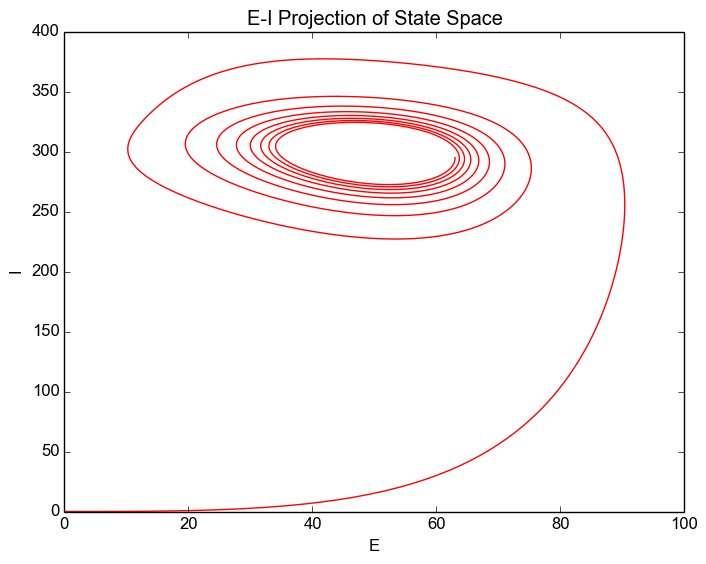

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] exp(::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}) at ./deprecated.jl:57
 [3] DelayedNegativeFeedback(::Float64) at ./In[172]:45
 [4] include_string(::String, ::String) at ./loading.jl:515
 [5] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/vis-528/.julia/v0.6/IJulia/src/execute_request.jl:160
 [6] eventloop(::ZMQ.Socket) at /home/vis-528/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##11#14)() at ./task.jl:335
while loading In[176], in expression starting on line 1


PyObject <matplotlib.text.Text object at 0x7f86211a2f90>

In [176]:
DelayedNegativeFeedback(10.74)

In [ ]:
# Binoc Rivalry
